In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
rounakbanik_the_movies_dataset_path = kagglehub.dataset_download('rounakbanik/the-movies-dataset')

print('Data source import complete.')


# Recommendation System- An Introduction

![](https://miro.medium.com/max/1132/1*N0-ikjPv4RUVvS-6KCgLPg.jpeg)

A recommendation system provides suggestions to the users through a filtering process that is based on user preferences and browsing history. The information about the user is taken as an input. The information is taken from the input that is in the form of browsing data. This information reflects the prior usage of the product as well as the assigned ratings. A recommendation system is a platform that provides its users with various contents based on their preferences and likings. A recommendation system takes the information about the user as an input. The recommendation system is an implementation of the machine learning algorithms.

A recommendation system also finds a similarity between the different products. For example, Netflix Recommendation System provides you with the recommendations of the movies that are similar to the ones that have been watched in the past. Furthermore, there is a collaborative content filtering that provides you with the recommendations in respect with the other users who might have a similar viewing history or preferences. There are two types of recommendation systems – Content-Based Recommendation System and Collaborative Filtering Recommendation.



# A walkthrough of the Notebook

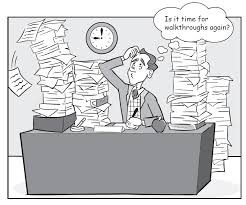

In this notebook, we will attempt at implementing a few recommendation algorithms (content based, popularity based and collaborative filtering) and try to build an ensemble of these models to come up with our final recommendation system. With us, we have two MovieLens datasets.

The Full Dataset: Comprises of 26,000,000 ratings and 750,000 tag applications applied to 45,000 movies by 270,000 users. Includes tag genome data with 12 million relevance scores across 1,100 tags.

The Small Dataset: Comprises of 100,000 ratings and 1,300 tag applications applied to 9,000 movies by 700 users.

We will build a Simple Recommender using movies from the Full Dataset whereas all personalised recommender systems will make use of the small dataset (due to the computing power I possess being very limited). As a first step, we will build my simple recommender system.

# Importing the Libraries

# Introducing- Surprise!!!

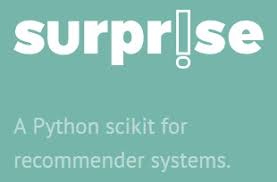

The name SurPRISE (roughly :) ) stands for Simple Python RecommendatIon System Engine.
Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data.

Surprise was designed with the following purposes in mind:

1. Give users perfect control over their experiments. To this end, a strong emphasis is laid on documentation, which we have tried to make as clear and precise as possible by pointing out every detail of the algorithms.
2. Alleviate the pain of Dataset handling. Users can use both built-in datasets (Movielens, Jester), and their own custom datasets.
3. Provide various ready-to-use prediction algorithms such as baseline algorithms, neighborhood methods, matrix factorization-based ( SVD, PMF, SVD++, NMF), and many others. Also, various similarity measures (cosine, MSD, pearson…) are built-in.
4. Make it easy to implement new algorithm ideas.
5. Provide tools to evaluate, analyse and compare the algorithms’ performance.

Please refer to the following link for any further information: http://surpriselib.com/

Installing the Library in the system

In [ ]:
!pip install scikit-surprise

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

pd.options.display.max_columns=None
#pd.set_option('display.max_colwidth', None)

import warnings; warnings.simplefilter('ignore')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Now we have installed the libraries and are ready for our model creation. Let us first see the simplest approach- i.e. The Simple Recommender

# The Simple Recommender Approach

The Simple Recommender offers generalized recommnendations to every user based on movie popularity and (sometimes) genre. The basic idea behind this recommender is that movies that are more popular and more critically acclaimed will have a higher probability of being liked by the average audience. This model does not give personalized recommendations based on the user.

The implementation of this model is extremely trivial. All we have to do is sort our movies based on ratings and popularity and display the top movies of our list. As an added step, we can pass in a genre argument to get the top movies of a particular genre.

> **Reading the Larger Dataset**

In [ ]:
meta = pd. read_csv('/content/credits.csv.zip')
meta.head()

> **Let's identify the total number of null values in the data:**

In [ ]:
meta.isnull().sum()

**Observation** Okay, so the dataset has sufficient number of null values- and it will be better if we can clean them. Also, we observe some of the columns have a list of dictionary structure- but it isn't a very easy format to read. So let's just clean it up to create an ordinary list.

> **Cleaning the Dataset**

In [ ]:
meta['genres'] = meta['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
meta['production_companies']= meta['production_companies'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
meta['production_countries'] = meta['production_countries'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
meta['spoken_languages'] = meta['spoken_languages'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
meta['year'] = pd.to_datetime(meta['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

> **Let's take a final look at the data before moving to our next steps**

In [ ]:
meta.head()

# Logic Implemented

We will use the IMDB Ratings to come up with our Top Movies Chart. I will use IMDB's weighted rating formula to construct my chart. Mathematically, it is represented as follows:

                            Weighted Rank (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C
where,

                             R = average for the movie (mean) = (Rating)
                             v = number of votes for the movie = (votes)
                             m = minimum votes required to be listed in the Top 250
                             C = the mean vote across the whole report
                             
The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 90th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 96% of the movies in the list.

I will build our overall Top 250 Chart and will define a function to build charts for a particular genre. Let's begin!

In [ ]:
vote_counts = meta[meta['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = meta[meta['vote_average'].notnull()]['vote_average'].astype('int')

In [ ]:
C = vote_averages.mean()
print('The Mean value of the voting averages= ',C)
m = vote_counts.quantile(0.96)
print('The minimum vote count for a movie to consider= ',m)

> **Creating the qualified database- upon whom we shall perfrom the next estimations**

In [ ]:
qualified = meta[(meta['vote_count'] >= m) & (meta['vote_count'].notnull()) & (meta['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
print('The structure of the qualified database is= ',qualified.shape)

Therefore, to qualify to be considered for the chart, a movie has to have at least 576.63 votes on TMDB. We also see that the average rating for a movie on TMDB is 5.244 on a scale of 10. Only 1899 Movies qualify to be on our chart.

In [ ]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)
qualified = qualified.sort_values('wr', ascending=False).head(250)

**Top Movies**

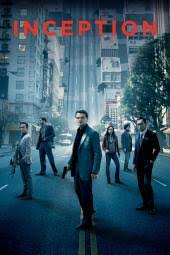

In [ ]:
qualified.head(15)

**Observations:** We see that three Christopher Nolan Films, Inception, The Dark Knight and Interstellar occur at the very top of our chart. The chart also indicates a strong bias of TMDB Users towards particular genres and directors.

Let us now construct our function that builds charts for particular genres. For this, we will use relax our default conditions to the 90th percentile instead of 96.

> **Pivoting down the entire dataset based on genres**

In [ ]:
s = meta.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = meta.drop('genres', axis=1).join(s)
gen_md.head(8)

So now, we will create a function that returns us the list of top movies for a genre!

In [ ]:
def build_chart(genre, percentile=0.90):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)

    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')

    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)

    return qualified

Let us see our method in action by displaying the Top 15 Horror Movies (Horror almost didn't feature at all in our Generic Top Chart despite being one of the most popular movie genres).

**Top Horror Movies**

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRPmfSkUQPZ6vrX5XqkPu2crntc3_kvi0FtWg&usqp=CAU)

In [ ]:
build_chart('Horror').head(15)

**Observations** Pretty frightening!!! But our predictions have done well. Just compared with the top horror movies list in IMDB- and the results were impressive.

Kindly refer to the following link for your reference-https://www.imdb.com/search/title/?genres=horror&title_type=feature&explore=genres

Let's lighten up ourselved with some movie that may lighten our moods- Lets look for some recommendations of the Romantic Genre

**Top Romantic Movies**

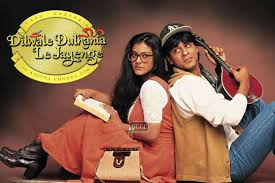

In [ ]:
build_chart('Romance').head(15)

**Observations:** Well no wonders, the movie "Dilwale Dulhaniya Le Jayenge" starring Shah Rukh Khan- the King of Romance would top this list!

# Content Based Recommender

The recommender we built in the previous section suffers some severe limitations. For one, it gives the same recommendation to everyone, regardless of the user's personal taste.

For a person who loves codemy movies (and hates drama) were to look at our Top 15 Chart,he/she wouldn't probably like most of the movies. If he/she were to go one step further and look at our charts by genre, still wouldn't be getting the best recommendations.

For instance, consider a person who loves Dilwale Dulhania Le Jayenge, My Name is Khan and Kabhi Khushi Kabhi Gham. One inference we can obtain is that the person loves the actor Shahrukh Khan and the director Karan Johar. Even if he/she were to access the romance chart, they wouldn't find these as the top recommendations.

To personalise our recommendations more, we will be going to build an engine that computes similarity between movies based on certain metrics and suggests movies that are most similar to a particular movie that a user liked.

Since we will be using movie metadata (or content) to build this engine, this also known as Content Based Filtering.

We will build two Content Based Recommenders based on:

1. Movie Overviews and Taglines
2. Movie Cast, Crew, Keywords and Genre

Also, as mentioned in the introduction, we will be using a subset of all the movies available to us due to limiting computing power available to me.

In [ ]:
links_small = pd.read_csv('/kaggle/input/the-movies-dataset/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [ ]:
links_small.head()

> Deleting the unwanted input rows. These rows required special treatments of processing, and also protrayed lower weighted scores- hence would not have been a part of the recommendations- So we can safely remove them

In [ ]:
meta = meta.drop([19730, 29503, 35587])

In [ ]:
meta['id'] = meta['id'].astype('int')

In [ ]:
smd = meta[meta['id'].isin(links_small)]
smd.shape

We have 9099 movies avaiable in our small movies metadata dataset which is 5 times smaller than our original dataset of 45000 movies.

**Movie Description Based Recommender**

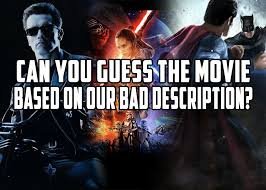

Let us first try to build a recommender using movie descriptions and taglines. We do not have a quantitative metric to judge our machine's performance so this will have to be done qualitatively.

In [ ]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

**We shall be using Tfidfvectorizer for this step.**

With Tfidftransformer you will systematically compute word counts using CountVectorizer and then compute the Inverse Document Frequency (IDF) values and only then compute the Tf-idf scores. However with Tfidfvectorizer on the contrary, you will do all three steps at once. Under the hood, it computes the word counts, IDF values, and Tf-idf scores all using the same dataset.

Please refer to the document for reference: https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.YD6EoyQzY2w

In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

Let's look at the shape of the TF-IDF Vectorizer

In [ ]:
tfidf_matrix.shape

**Cosine Similarity**
I will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies. Mathematically, it is defined as follows:

cosine(x,y)=(x.y⊺)/(||x||.||y||)

Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [ ]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[0]

We now have a pairwise cosine similarity matrix for all the movies in our dataset. The next step is to write a function that returns the 20 most similar movies based on the cosine similarity score.

In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [ ]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

We're all set. Let us now try and get the top recommendations for a few movies and see how good the recommendations are. We shall take a look into the Indian Movie- **3 Idiots**. I personnaly love that movie- being an engineering student, this movie takes me back to the college days!

So before checking the recommendations- let us check what is the **description of this movie?**

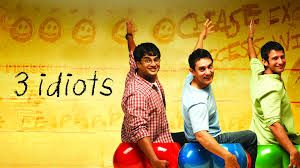

In [ ]:
movie='3 Idiots'
print("Description of the Movie: ", movie)
print('---------------------------------------------------------------------')
print(smd[smd['title']==movie]['overview'])

**Observations:** Okay lets jot down a few points that we need to look for in the recommendations.
1. Firstly “Ferris Bueller’s Day Off”- so we get an idea that this movie might be a recommendation.
2. A rebellious prankster in the college and his story with the lives of his two newfound best friends.
3. The Dean of the college is uptight and heartless- and his name is "Virus"
4. The Dean has a beautiful daughter- who shall be the love interest of the protagonist

So gathering up the points, lets just check our recommendations!

In [ ]:
get_recommendations('3 Idiots').head(20)

**Observation:** Cool! The first movie predicted is- "Ferris Bueller's Day Off", which is present in the description.

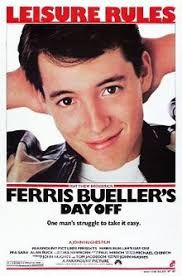

Indeed nice choice. We also see college oriented movies like Student of the year, College and Hackers.

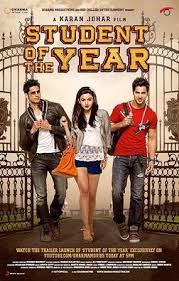

The thing which I was amused with most is since the name of the Dean was "Virus"- movies like Outbreak and Contagion have been predicted.

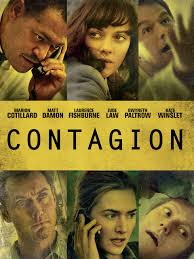

Now a point that surprises me is why Lion King? Is it because of the two best friends- maybe an hint to Timon and Pumba! Woah! That was an interesting one

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQeUwVrHEpGQHWgitOSt3gZiNIW4g5RidibGg&usqp=CAU)

So indeed we have been able to go for nice predictions!!! I already love it!






> Now let us look into another movie- another classic- **The Dark Knight** - but before checking, we shall look into the description here as well
>
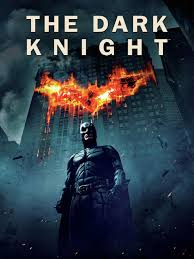

In [ ]:
movie='The Dark Knight'
print("Description of the Movie: ", movie)
print('---------------------------------------------------------------------')
print(smd[smd['title']==movie]['overview'])

**Observation** Well, as we have all seen- the movie is mainly the story of Batman, and how he fights criminals to protect the city of Gotham. Another very important part of this movie will be the main antagonist- the Joker. Lets take a look at the recommendations now!

In [ ]:
get_recommendations('The Dark Knight').head(20)

**Observations:** We see that for The Dark Knight, our system is able to identify it as a Batman film and subsequently recommend other Batman films as its top recommendations.

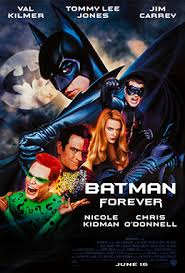

However based on the mention of criminal organizations in the description- there are also some movies recommended that were on the theme of Police and Crimes- To End all Wars, Q&A etc

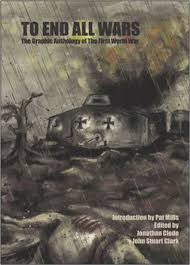

> But unfortunately, that is all this system can do at the moment. This is not of much use to most people as it doesn't take into considerations very important features such as cast, crew, director and genre, which determine the rating and the popularity of a movie. Someone who liked The Dark Knight probably likes it more because of Nolan and would hate Batman Forever and every other substandard movie in the Batman Franchise.
>
> Therefore, we are going to use much more suggestive metadata than Overview and Tagline. In the next subsection, we will build a more sophisticated recommender that takes genre, keywords, cast and crew into consideration.

# Metadata Based Recommender
To build our standard metadata based content recommender, we will need to merge our current dataset with the crew and the keyword datasets. Let us prepare this data as our first step.

In [ ]:
credits = pd.read_csv('/kaggle/input/the-movies-dataset/credits.csv')
keywords = pd.read_csv('/kaggle/input/the-movies-dataset/keywords.csv')

In [ ]:
keywords.head()

In [ ]:
credits.head()

In [ ]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
meta['id'] = meta['id'].astype('int')
meta.shape

In [ ]:
meta = meta.merge(credits, on='id')
meta = meta.merge(keywords, on='id')

Let's look at the shape of the smaller metadata

In [ ]:
smd = meta[meta['id'].isin(links_small)]
smd.shape

We now have our cast, crew, genres and credits, all in one dataframe. Let us wrangle this a little more using the following intuitions:

1. **Crew:** From the crew, we will only pick the director as our feature since the others don't contribute that much to the feel of the movie.The director's touch was the most important parameter as we have seen in the above segment.

2. **Cast:** Choosing Cast is a little more tricky. Lesser known actors and minor roles do not really affect people's opinion of a movie. Therefore, we must only select the major characters and their respective actors. Arbitrarily we will choose the top 4 actors that appear in the credits list.

In [ ]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
smd['director'] = smd['crew'].apply(get_director)

In [ ]:
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:4] if len(x) >=4 else x)


In [ ]:
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

Our approach to building the recommender is going to be extremely hacky. What we plan on doing is creating a metadata dump for every movie which consists of genres, director, main actors and keywords. Then we use a similar apporach as above-i.e. Count Vectorizer to create our count matrix as we did in the Description Recommender.
The remaining steps would be similar to what we did earlier: we calculate the cosine similarities and return movies that are most similar.

These are steps that we need to follow in the preparation of genres and credits data:

1. Strip Spaces and Convert to Lowercase from all our features. This way, our engine will not confuse between George Clooney and George Hamilton.
2. Mention Director 3 times to give it more weight relative to the entire cast

In [ ]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x,x])

Keywords

We will do a small amount of pre-processing of our keywords before putting them to any use. As a first step, we calculate the frequenct counts of every keyword that appears in the dataset.

In [ ]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [ ]:
s = s.value_counts()
s[:10]

Keywords occur in frequencies ranging from 1 to 610. We do not have any use for keywords that occur only once. Therefore, these can be safely removed.

In [ ]:
s = s[s > 1]

Finally, we will convert every word to its stem so that words such as Sportingly and Sport are considered the same.

In [ ]:
stemmer = SnowballStemmer('english')
stemmer.stem('sportingly')

In [ ]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [ ]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

Applying the same Count Vectorizer and Cosine Similarity as mentioned:

In [ ]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [ ]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

We will reuse the get_recommendations function that we had written earlier. Since our cosine similarity scores have changed, we expect it to give us different (and probably better) results. Let us check for The Dark Knight again and see what recommendations I get this time around.

In [ ]:
get_recommendations('The Dark Knight').head(15)

I am much more satisfied with the results I get this time around. The recommendations seem to have recognized other Christopher Nolan movies (due to the high weightage given to director) and put them as top recommendations.

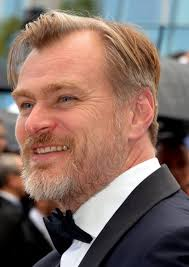

Also adding the cast we got other movies of the same actors into the recommendation list- The Prestige (Cristian Bale), Thursday (Aaron Eckhart or better known as Harvey Dent), Interstellar (Michael Caine) etc. The movies where the actors have collaborated with Nolan earned the highest ranks in the recommended list. That was quite amazing!

![](https://media.gettyimages.com/photos/michael-caine-christian-bale-maggie-gyllenhaal-and-aaron-eckhart-at-picture-id834728940)

We can of course experiment on this engine by trying out different weights for our features (directors, actors, genres), limiting the number of keywords that can be used in the soup, weighing genres based on their frequency, only showing movies with the same languages, etc.

Let us also get recommendations for another movie.

I was really fascinated by the movie **"Mrs. Doubtfire"** when I was a Kid- and it made me a huge fan of Robin Williams. Lets try to see what would be the recommendations for a user interested in the movie!

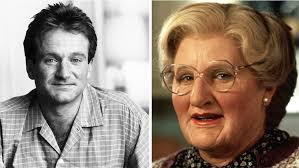

In [ ]:
get_recommendations('Mrs. Doubtfire').head(15)

**Observations** I was ignorant of the fact that Mrs. Doubtfire, Home Alone Series and the first few movies of Harry Potter were directed by the same person-**Chris Columbus**!

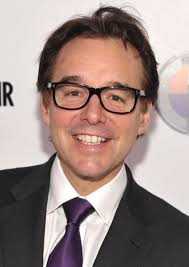

This model creation really improved my knowledge on the world of movies! :)

Also based on the actors- Nine Months and Bicentennial Man had Robin Williams in the Lead, while for Percy Jackson & the Olympians: The Lightning Thief, we had Pierce Brosnan in the Lead, and both have worked together for Mrs. Doubtfire!  

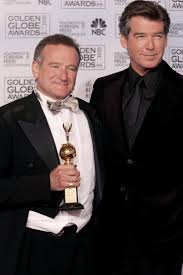

So in short, we have been succesful in our target of recommending the movies based on the cast and crew- with a special importance to the director.

But,one thing that we notice about our recommendation system is that it recommends movies regardless of ratings and popularity.

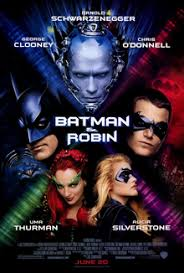

It is true that Batman and Robin has a lot of similar characters as compared to The Dark Knight but it was a terrible movie that shouldn't be recommended to anyone.

Therefore, we will add a mechanism to remove bad movies and return movies which are popular and have had a good critical response.

I will take the top 15 movies based on similarity scores and calculate the vote of the 50th percentile movie. Then, using this as the value of  m , we will calculate the weighted rating of each movie using IMDB's formula like we did in the Simple Recommender section.


In [ ]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]

    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.50)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [ ]:
improved_recommendations('The Dark Knight')

Fortunately, Batman and Robin does not appear from our recommendation list. So we can infer that we have been succesfully able to filter only the movies that have a good rating, as well as match our desired outcome as seen above

In [ ]:
improved_recommendations('Mrs. Doubtfire')

**Observation** Based on rating parameters, Harry Potter movies tops this list now. Indeed they were loved and appreciated by the audience.

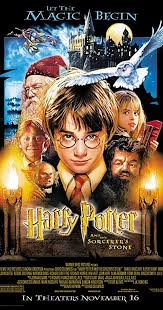

Now let's take a look into a new concept- "**Collaborative Filtering**"

# Collaborative Filtering Application

Uptill now the recommender that we have created, our content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who s/he is.

Therefore, in this section, we will use a technique called Collaborative Filtering to make recommendations to Movie Watchers. Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

We shall not be implementing Collaborative Filtering from scratch. Instead, I will use the Surprise library that used extremely powerful algorithms like Singular Value Decomposition (SVD) to minimise RMSE (Root Mean Square Error) and give great recommendations.

To get an understanding of the algorithm, please go through the following link: https://towardsdatascience.com/understanding-singular-value-decomposition-and-its-application-in-data-science-388a54be95d#:~:text=In%20linear%20algebra%2C%20the%20Singular,important%20applications%20in%20data%20science.

In [ ]:
reader = Reader()
ratings = pd.read_csv('/kaggle/input/the-movies-dataset/ratings_small.csv')
ratings.head()

In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'],cv=5)

We get a mean Root Mean Sqaure Error of 0.8944 which is more than good enough for our case. Let us now train on our dataset and arrive at predictions.

In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
user_rating=pd.merge(ratings,meta,left_on='movieId',right_on='id',how='inner')
user_ratings_final=user_rating[['userId', 'movieId', 'rating','original_title']]
user_ratings=user_ratings_final.sort_values(by='userId')
user_ratings.head()

Now we shall be checking for a particular user- as to what are the ratings he/she has given to the movies watched. Based on that we shall be trying to predict what will be the rating he/she shall give to a new movie. Seems pretty interesting isn't it?

Let us choose User no. 7. First lets take a look into the movies he/she has watched.

In [ ]:
user_ratings[user_ratings['userId'] == 7]

**Observations** Okay what we see is, the user here has seen multiple movies from the action and horror genres. So in order to test on this particular user, let us choose two movies that he/she did not watch- and accordingly shall predict his/her ratings for the same.

Lets Choose a movie:

1. Since he has watched multiple horror movies- will give him a horror movie to estimate his ratings. Our choice: The Conjuring

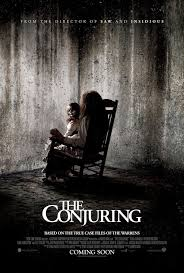

First, lets identify the Movie Id for this movie...

In [ ]:
movie1=meta['original_title']=='The Conjuring'
meta[movie1][['original_title','id']]

So, lets see how much will the user like the movie "The Conjuring"

In [ ]:
svd.predict(7, 138843, 3)

**Observations** Okay, 3.27 is a mediocre rating.But if we check the movies listed above, he/she has mostly rated them a 3- so in that order, a 3.27 seems better than those.

# A Combination Recommender

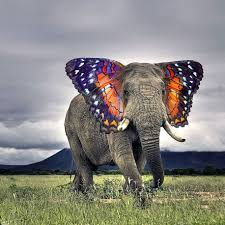

In this section, we will try to build a movie recommender that brings together techniques we have implemented in the content based and collaborative filter based engines. This is how it will work:

For this we shall be creating a function recommend_my_movie()- which will be responsible to provide out the recommendation list

**Input:**
User ID and the Title of a Movie

**Output:**
Similar movies sorted on the basis of expected ratings by that particular user.

In [ ]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [ ]:
id_map = pd.read_csv('/kaggle/input/the-movies-dataset/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')

In [ ]:
indices_map = id_map.set_index('id')

In [1]:
def recommend_my_movie(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

Let's check for the 7th User we had just seen above!

In [ ]:
recommend_my_movie(7, "Inception")

Now, just for the sake of comparing- we are choosing a different user. But trying to get the recommendations on the same movie.

Lets just choose user 25 for our reference!

In [ ]:
recommend_my_movie(25, "Inception")

We see that for our hybrid recommender, we get different recommendations for different users although the movie is the same. Hence, our recommendations are more personalized and tailored towards particular users.

I really ennjoyed my work working on this particular model- and shall be working on further to improve this

# Conclusions

In this notebook, we have built 4 different recommendation engines based on different ideas and algorithms. They are as follows:

1. **Simple Recommender**: This system used overall TMDB Vote Count and Vote Averages to build Top Movies Charts, in general and for a specific genre. The IMDB Weighted Rating System was used to calculate ratings on which the sorting was finally performed.

2. **Content Based Recommender**: We built two content based engines; one that took movie overview and taglines as input and the other which took metadata such as cast, crew, genre and keywords to come up with predictions. We also deviced a simple filter to give greater preference to movies with more votes and higher ratings.

3. **Collaborative Filtering Approach**: We used the powerful Surprise Library to build a collaborative filter based on single value decomposition. The RMSE obtained was less than 1 and the engine gave estimated ratings for a given user and movie.

4. **Combined Recommendation Engine**: We brought together ideas from content and collaborative filterting to build an engine that gave movie suggestions to a particular user based on the estimated ratings that it had internally calculated for that user.

Overall the data source is very well oriented, and not much of a cleaning task was required. Will be adding on many more updates!!!

![](https://i.pinimg.com/originals/4e/9e/6f/4e9e6f979347906a426adcbe57fd3259.gif)